In [264]:
import jax
from jax import lax
import jax.numpy as jnp
from flax import linen as nn
import optax

import numpy as np
import matplotlib.pyplot as plt

import pickle
from pytorch_fid import fid_score
from PIL import Image
import os

In [265]:
# Initialize the Generator and Discriminator
latent_dim = 128
num_classes = 10  # For MNIST, there are 10 classes (digits 0-9)
image_size = 28 * 28  # MNIST image size
embedding_dim = 10
batch_size = 64
validation_size = 10000

rng = jax.random.PRNGKey(0)

num_epochs = 1000
gen_alpha = 0.5
gen_beta = 0.999
disc_alpha = 0.5
disc_beta = 0.999
gen_learning_rate = 1e-4
disc_learning_rate = 5e-5

MODEL_PATH = "small"

In [266]:
MODEL_DIR = "models"

def load_params(path):
    model_path = os.path.join(MODEL_DIR, path)
    with open(model_path, "rb") as f:
        model_params = pickle.load(f)
    return model_params

def save_params(model_params, path):
    model_path = os.path.join(MODEL_DIR, path)
    with open(model_path, "wb") as f:
        pickle.dump(model_params, f)

In [267]:
MNIST_DIR = "MNIST"

def load_mnist(kind='train'):
    labels_path = os.path.join(MNIST_DIR, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(MNIST_DIR, f'{kind}-images-idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        labels = jnp.frombuffer(lbpath.read(), dtype=jnp.uint8, offset=8)

    with open(images_path, 'rb') as imgpath:
        images = jnp.frombuffer(imgpath.read(), dtype=jnp.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

# Load MNIST dataset
train_images, train_labels = load_mnist(kind='train')
test_images, test_labels = load_mnist(kind='t10k')

# Print shapes to verify
print('Training data shape:', train_images.shape)
print('Training labels shape:', train_labels.shape)
print('Test data shape:', test_images.shape)
print('Test labels shape:', test_labels.shape)

Training data shape: (60000, 784)
Training labels shape: (60000,)
Test data shape: (10000, 784)
Test labels shape: (10000,)


In [268]:
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

In [269]:
def show_digits(images, labels=None, figsize=(20, 6)):
    n = len(images)
    num_cols = 10
    num_rows = np.ceil(n / num_cols).astype(int)

    fig, axs = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=figsize)
    axs = axs.reshape((-1,))
    for i in range(num_rows*num_cols):
        if i < n:
            axs[i].imshow(images[i], cmap="gray")
            if labels is not None:
                axs[i].set_title(labels[i])
        axs[i].axis("off")

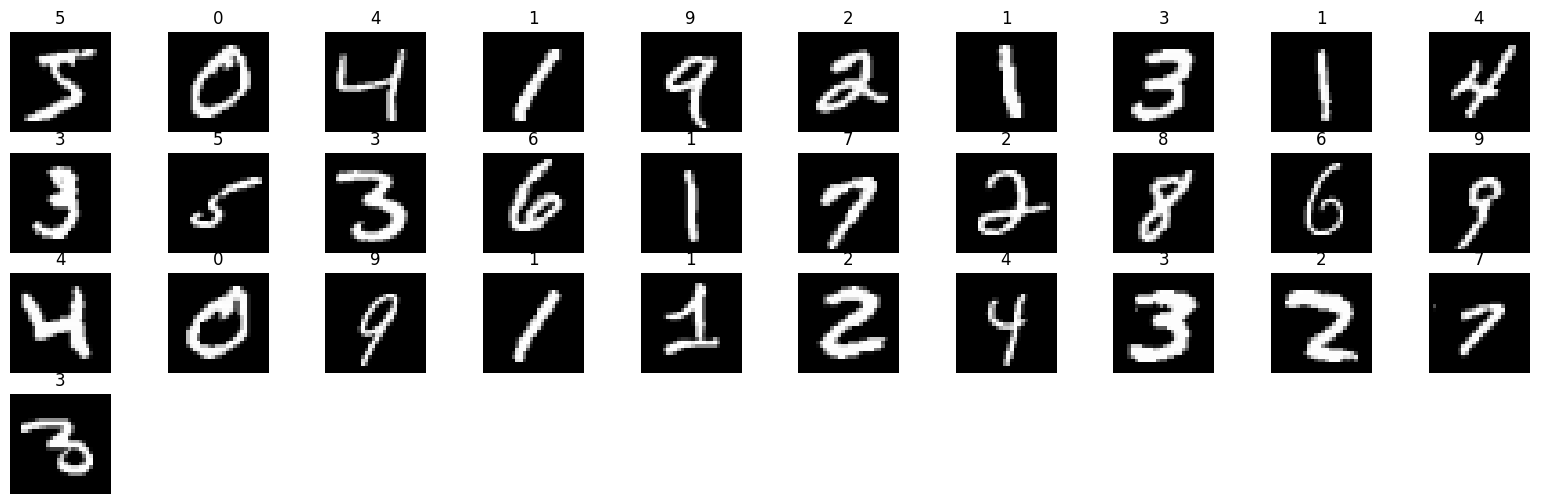

In [270]:
show_digits(train_images[:31], train_labels[:31])

In [271]:
# Explore the dataset
print("Train images: ", train_images.shape[0])
print("Test images: ", test_images.shape[0])
print("Image shape: ", train_images.shape[1:])

print("\nNumber of classes: ", len(jnp.unique(train_labels)))
print("class 0: ", jnp.sum(train_labels == 0))
print("class 1: ", jnp.sum(train_labels == 1))
print("class 2: ", jnp.sum(train_labels == 2))
print("class 3: ", jnp.sum(train_labels == 3))
print("class 4: ", jnp.sum(train_labels == 4))
print("class 5: ", jnp.sum(train_labels == 5))
print("class 6: ", jnp.sum(train_labels == 6))
print("class 7: ", jnp.sum(train_labels == 7))
print("class 8: ", jnp.sum(train_labels == 8))
print("class 9: ", jnp.sum(train_labels == 9))

Train images:  60000
Test images:  10000
Image shape:  (28, 28, 1)

Number of classes:  10
class 0:  5923
class 1:  6742
class 2:  5958
class 3:  6131
class 4:  5842
class 5:  5421
class 6:  5918
class 7:  6265
class 8:  5851
class 9:  5949


In [272]:
# Shuffle training data
rng, key = jax.random.split(rng)
idx = jax.random.permutation(key, train_images.shape[0])

train_images = train_images[idx]
train_labels = train_labels[idx]

# Normalize the images
train_images = train_images / 255.0

# Scale the images to the range [-1, 1]
train_images = 2 * train_images - 1

# Convert to jax array and split into training and validation sets
val_images, val_labels = jnp.array(train_images[:validation_size]), jnp.array(train_labels[:validation_size])
train_images, train_labels = jnp.array(train_images[validation_size:]), jnp.array(train_labels[validation_size:])
test_images, test_labels = jnp.array(test_images), jnp.array(test_labels)

# Print shapes to verify
print('Training data shape:', train_images.shape)
print('Training labels shape:', train_labels.shape)

print('Validation data shape:', val_images.shape)
print('Validation labels shape:', val_labels.shape)

print('Test data shape:', test_images.shape)
print('Test labels shape:', test_labels.shape)

Training data shape: (50000, 28, 28, 1)
Training labels shape: (50000,)
Validation data shape: (10000, 28, 28, 1)
Validation labels shape: (10000,)
Test data shape: (10000, 28, 28, 1)
Test labels shape: (10000,)


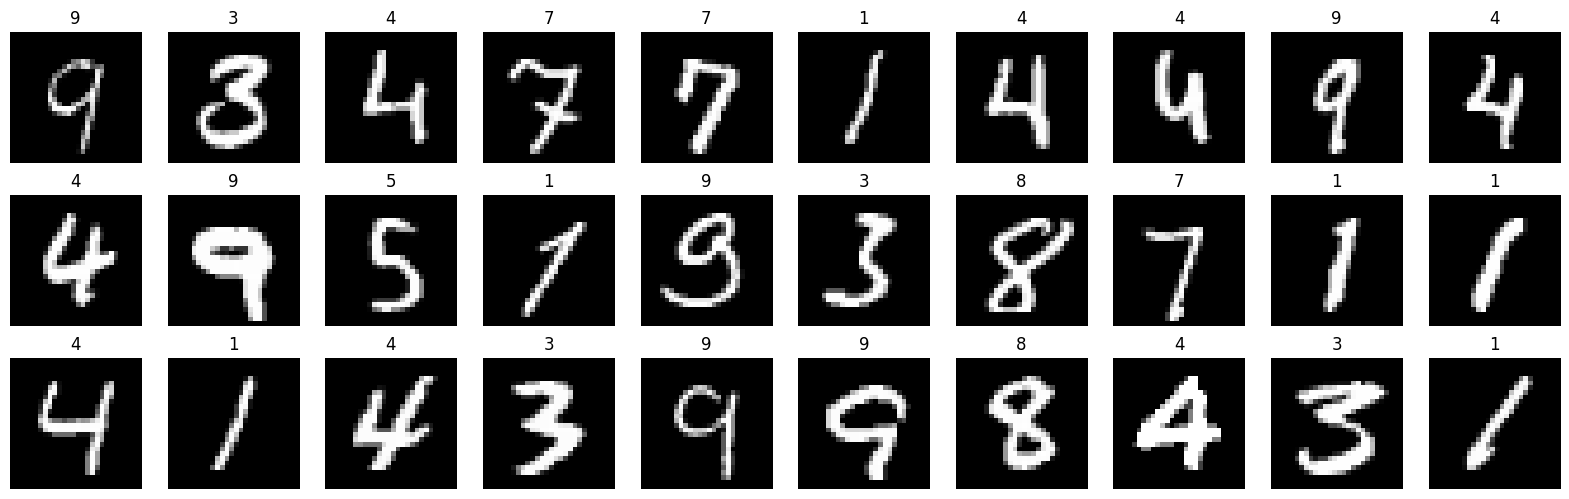

In [273]:
show_digits(train_images[::train_images.shape[0]//30][:30], train_labels[::train_images.shape[0]//30][:30])

### Generator and Discriminator Networks

The **Generator** creates fake images from random noise, while the **Discriminator** distinguishes between real and fake images.

- **Generator:**
  - Takes a latent vector as input.
  - Uses two hidden layers with ReLU activation.
  - Outputs an image with pixel values scaled between `[-1, 1]` using Tanh.

- **Discriminator:**
  - Takes an image as input.
  - Uses two hidden layers with Leaky ReLU activation.
  - Outputs a single value (logit) indicating the probability of the image being real.

In [274]:
class Generator(nn.Module):
    num_classes: int
    latent_dim: int

    @nn.compact
    def __call__(self, z, labels):
        # Hot encode the labels
        labels = nn.one_hot(labels, self.num_classes)
        x = jnp.concatenate([z, labels], axis=-1)

        # Generator network
        x = nn.Dense(128, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(256, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.relu(x)
        x = nn.Dense(28 * 28, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.tanh(x)
        
        return x.reshape(-1, 28, 28, 1)
    
class Discriminator(nn.Module):
    num_classes: int
    embedding_dim: int

    @nn.compact
    def __call__(self, x, labels):
        # Embed the labels
        label_embed = nn.Embed(num_embeddings=self.num_classes, features=self.embedding_dim)(labels)

        # Concatenate the images with the label embeddings
        x = x.reshape(-1, 28 * 28) # Flatten the images
        x = jnp.concatenate([x, label_embed], axis=-1)

        # Discriminator network
        x = nn.Dense(256, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Dense(128, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Dense(1, kernel_init=nn.initializers.xavier_uniform())(x)
        x = nn.sigmoid(x)
        
        return x

qualche commento

In [275]:
# Create Generator and Discriminator instances
gen = Generator(num_classes=num_classes, latent_dim=latent_dim)
disc = Discriminator(num_classes=num_classes, embedding_dim=embedding_dim)

# Create optimizers
# lr_schedule = optax.exponential_decay(init_value=1e-4, decay_rate=0.9, decay_steps=5000)
# optimizer = optax.adam(learning_rate=lr_schedule)

gen_optimizer = optax.adam(gen_learning_rate, b1=gen_alpha, b2=gen_beta)
disc_optimizer = optax.adam(disc_learning_rate, b1=disc_alpha, b2=disc_beta)

if False:
    gen_params, disc_params, gen_opt_state, disc_opt_state, loss_history, fid_value = load_params()
else:
    # Initialize the generator and discriminator parameters
    rng, gen_key, disc_key = jax.random.split(rng, 3)
    gen_params = gen.init(gen_key, jnp.ones((1, latent_dim)), jnp.array([0]))
    disc_params = disc.init(disc_key, jnp.ones((1, 28, 28, 1)), jnp.array([1]))

    # Initialize optimizer states
    gen_opt_state = gen_optimizer.init(gen_params)
    disc_opt_state = disc_optimizer.init(disc_params)

    # Loss history
    loss_history = []

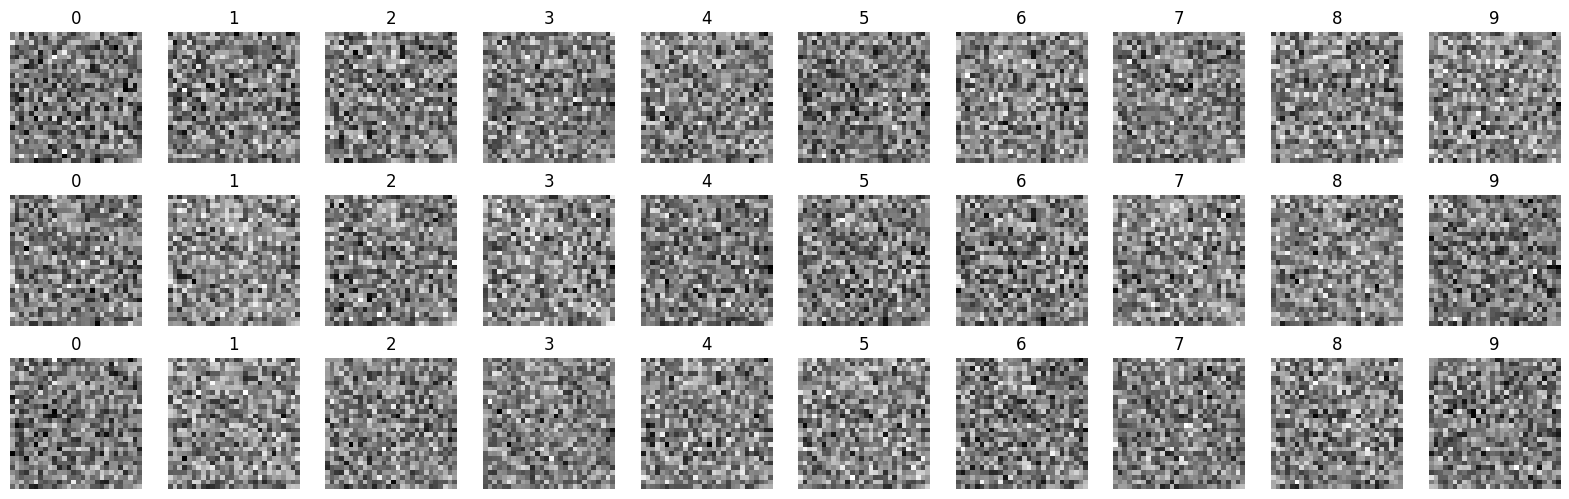

In [276]:
show_digits(gen.apply(gen_params, jax.random.normal(gen_key, (30, latent_dim)), jnp.arange(30)%10), jnp.arange(30)%10)

In [277]:
# Print generator parameters
print("Generator parameters:")
for param_name, layer in gen_params['params'].items():
    if param_name == "Embed_0":
        print(f"  Shape of {param_name}:\n    Embedding", layer['embedding'].shape)
    else:
        print(f"  Shape of {param_name}:\n    Bias: {layer['bias'].shape}\n    Kernel: {layer['kernel'].shape}")

# Print discriminator parameters
print("\nDiscriminator parameters:")
for param_name, layer in disc_params['params'].items():
    if param_name == "Embed_0":
        print(f"  Shape of {param_name}:\n    Embedding", layer['embedding'].shape)
    else:
        print(f"  Shape of {param_name}:\n    Bias: {layer['bias'].shape}\n    Kernel: {layer['kernel'].shape}")

Generator parameters:
  Shape of Dense_0:
    Bias: (128,)
    Kernel: (138, 128)
  Shape of Dense_1:
    Bias: (256,)
    Kernel: (128, 256)
  Shape of Dense_2:
    Bias: (784,)
    Kernel: (256, 784)

Discriminator parameters:
  Shape of Embed_0:
    Embedding (10, 10)
  Shape of Dense_0:
    Bias: (256,)
    Kernel: (794, 256)
  Shape of Dense_1:
    Bias: (128,)
    Kernel: (256, 128)
  Shape of Dense_2:
    Bias: (1,)
    Kernel: (128, 1)


### GAN Loss Functions

#### Discriminator Loss $ L_D $

The discriminator loss $ L_D $ is a binary cross-entropy loss, defined as:

$$
L_D = - \mathbb{E}_{x \sim p_{\text{data}}} \left[ \log D(x) \right] - \mathbb{E}_{z \sim p_z} \left[ \log \left( 1 - D(G(z)) \right) \right]
$$

Where:
- $ D(x) $ should output 1 for real images.
- $ D(G(z)) $ should output 0 for fake images generated by $ G(z) $.

This loss encourages the discriminator to correctly classify real and fake images.

#### Generator Loss $ L_G $

The generator loss $ L_G $ aims to fool the discriminator into classifying fake images as real. It is typically defined as:

$$
L_G = - \mathbb{E}_{z \sim p_z} \left[ \log D(G(z)) \right]
$$

Where:
- $ D(G(z)) $ represents the discriminator’s probability of classifying a generated image $ G(z) $ as real.

This loss encourages the generator to improve its ability to produce images that the discriminator cannot distinguish from real ones.

In [278]:
@jax.jit
def generator_loss(gen_params, disc_params, z, labels):
    # Generate fake images from two different latent vectors
    fake_images1 = gen.apply(gen_params, z, labels)

    # Get the discriminator's predictions on the first set of fake images
    fake_preds = disc.apply(disc_params, fake_images1, labels)

    return -jnp.mean(jnp.log(jnp.clip(fake_preds, 1e-7, 1.0)))

@jax.jit
def discriminator_loss(disc_params, real_images, fake_images, labels):
    # Get the discriminator's predictions on real and fake images
    real_preds = disc.apply(disc_params, real_images, labels)
    fake_preds = disc.apply(disc_params, fake_images, labels)

    # Calculate the loss
    real_loss = -jnp.mean(jnp.log(jnp.clip(real_preds, 1e-7, 1.0)))
    fake_loss = -jnp.mean(jnp.log(jnp.clip(1.0 - fake_preds, 1e-7, 1.0)))

    return real_loss + fake_loss

Commento

In [279]:
rng, key = jax.random.split(rng)
sample_z = jax.random.normal(key, (10, latent_dim))
sample_labels = jnp.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
gen_images = []

In [280]:
num_batches = train_images.shape[0] // batch_size

@jax.jit
def train_generator_epoch(gen_params, disc_params, gen_opt_state, zs, train_labels):
    def gen_step(i, state):
        gen_params, gen_opt_state, gen_loss = state
        
        # Correct dynamic slice for labels, slice only along the batch dimension (axis 0)
        labels = lax.dynamic_slice(train_labels, start_indices=(i * batch_size,), slice_sizes=(batch_size,))
        z = zs[i]
        
        # Calculate the generator loss (Depends on both the generator and discriminator parameters)
        gen_loss, gen_grads = jax.value_and_grad(generator_loss)(gen_params, disc_params, z, labels)

        # Update generator
        gen_updates, gen_opt_state = gen_optimizer.update(gen_grads, gen_opt_state)
        gen_params = optax.apply_updates(gen_params, gen_updates)
        
        return gen_params, gen_opt_state, gen_loss + state[2]

    gen_params, gen_opt_state, total_gen_loss = jax.lax.fori_loop(0, num_batches, gen_step, (gen_params, gen_opt_state, 0.0))
    return gen_params, gen_opt_state, total_gen_loss / num_batches

@jax.jit
def train_discriminator_epoch(disc_params, gen_params, disc_opt_state, zs, train_images, train_labels):
    def disc_step(i, state):
        disc_params, disc_opt_state, disc_loss = state
        
        # Correct dynamic slice for real images, slice only along the batch dimension (axis 0)
        real_images = lax.dynamic_slice(train_images, start_indices=(i * batch_size, 0, 0, 0), slice_sizes=(batch_size, 28, 28, 1))
        labels = lax.dynamic_slice(train_labels, start_indices=(i * batch_size,), slice_sizes=(batch_size,))
        
        z = zs[i]
        fake_images = gen.apply(gen_params, z, labels)
        
        # Calculate the discriminator loss (Should only depend on the discriminator parameters)
        disc_loss, disc_grads = jax.value_and_grad(discriminator_loss)(disc_params, real_images, fake_images, labels)

        # Update discriminator
        disc_updates, disc_opt_state = disc_optimizer.update(disc_grads, disc_opt_state)
        disc_params = optax.apply_updates(disc_params, disc_updates)
        
        return disc_params, disc_opt_state, disc_loss + state[2]

    disc_params, disc_opt_state, total_disc_loss = jax.lax.fori_loop(0, num_batches, disc_step, (disc_params, disc_opt_state, 0.0))
    return disc_params, disc_opt_state, total_disc_loss / num_batches

# Main loop
for epoch in range(num_epochs):
    # Shuffle dataset and generate latent vectors
    rng, shuffle_key, z_key = jax.random.split(rng, 3)
    indices = jax.random.permutation(shuffle_key, jnp.arange(train_images.shape[0]))
    train_images = train_images[indices]
    train_labels = train_labels[indices]
    zs = jax.random.normal(z_key, (num_batches, batch_size, latent_dim))

    # Train generator and discriminator
    gen_params, gen_opt_state, epoch_gen_loss = train_generator_epoch(gen_params, disc_params, gen_opt_state, zs, train_labels)
    disc_params, disc_opt_state, epoch_disc_loss = train_discriminator_epoch(disc_params, gen_params, disc_opt_state, zs, train_images, train_labels)

    # Log losses
    loss_history.append((epoch_gen_loss, epoch_disc_loss))
    print(f"Epoch {epoch}, Generator loss: {epoch_gen_loss:.4f}, Discriminator loss: {epoch_disc_loss:.4f}")
    
    # Generate samples every 10 epochs
    if (epoch + 1) % 10 == 0:
        gen_images.append(gen.apply(gen_params, sample_z, sample_labels))

Epoch 0, Generator loss: 0.0113, Discriminator loss: 0.3130
Epoch 1, Generator loss: 0.0191, Discriminator loss: 0.0434
Epoch 2, Generator loss: 0.0239, Discriminator loss: 0.0402
Epoch 3, Generator loss: 0.0226, Discriminator loss: 0.0357
Epoch 4, Generator loss: 0.0204, Discriminator loss: 0.0355
Epoch 5, Generator loss: 0.0172, Discriminator loss: 0.0349
Epoch 6, Generator loss: 0.0153, Discriminator loss: 0.0382
Epoch 7, Generator loss: 0.0133, Discriminator loss: 0.0471
Epoch 8, Generator loss: 0.0121, Discriminator loss: 0.0599
Epoch 9, Generator loss: 0.0111, Discriminator loss: 0.0798
Epoch 10, Generator loss: 0.0103, Discriminator loss: 0.0884
Epoch 11, Generator loss: 0.0095, Discriminator loss: 0.0783
Epoch 12, Generator loss: 0.0098, Discriminator loss: 0.0692
Epoch 13, Generator loss: 0.0094, Discriminator loss: 0.0541
Epoch 14, Generator loss: 0.0097, Discriminator loss: 0.0360
Epoch 15, Generator loss: 0.0098, Discriminator loss: 0.0297
Epoch 16, Generator loss: 0.0104, 

KeyboardInterrupt: 

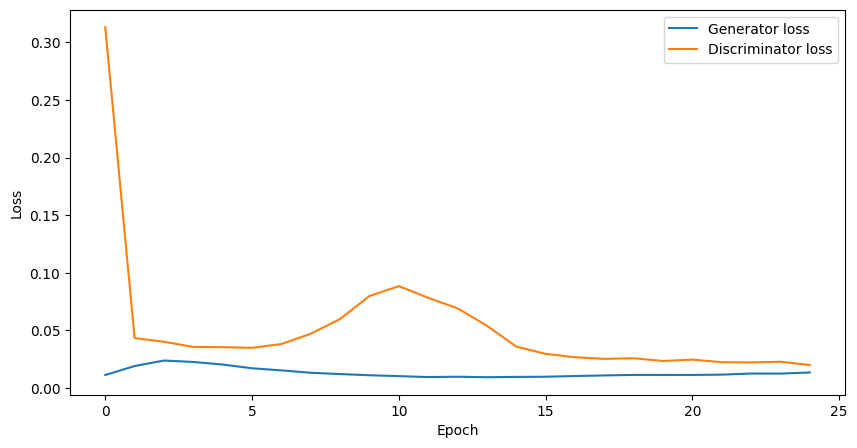

In [281]:
# Plot the losses
gen_losses, disc_losses = zip(*loss_history)
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label="Generator loss")
plt.plot(disc_losses, label="Discriminator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

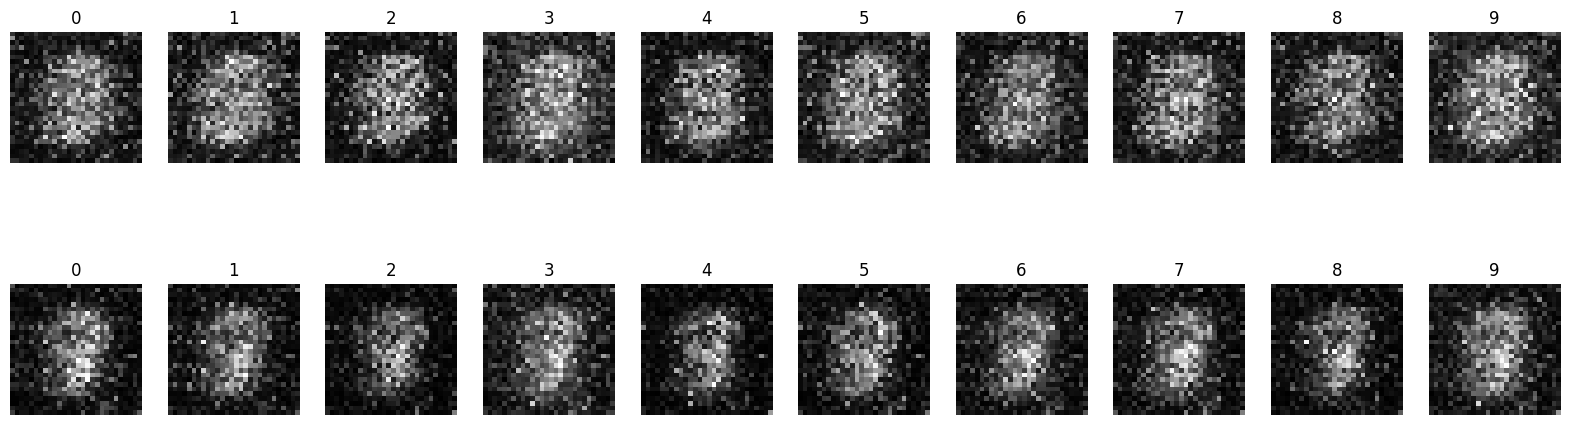

In [283]:
show_digits(jnp.concatenate(gen_images), jnp.concatenate([jnp.arange(10)]*len(gen_images)))

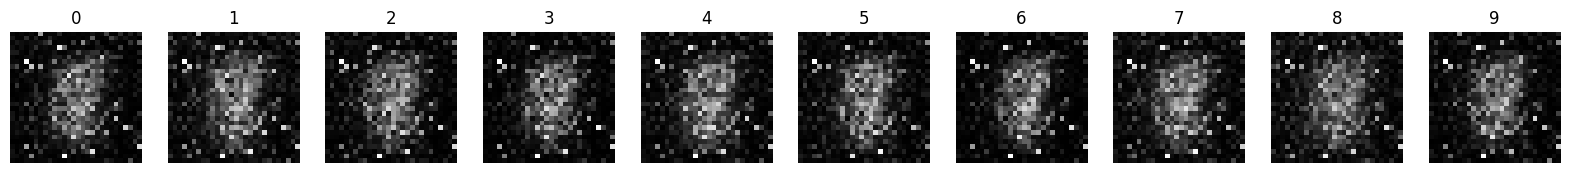

In [284]:
rng, key = jax.random.split(rng)
z = jax.random.normal(key, (10, latent_dim))
labels = jnp.arange(10)
show_digits(gen.apply(gen_params, z, labels), labels)

In [285]:
def save_images(images_array, save_dir, denorm=False):
    os.makedirs(save_dir, exist_ok=True)

    for i in range(images_array.shape[0]):  # Loop over N images
        img_array = images_array[i]

        # Convert to PIL Image
        if denorm:
            img_array = ((img_array + 1) * 127.5).astype(np.uint8)
        img = Image.fromarray(img_array.reshape(28, 28))  # Scale to 0-255

        # Convert grayscale to RGB
        img = img.convert("RGB")

        img = img.resize((299, 299), Image.LANCZOS)

        # Save as PNG
        img.save(os.path.join(save_dir, f"image_{i:05d}.png"))

def generate_samples(params, labels, path="generated_images", num_imgs=10000):
    samples = []
    batch_size = 64

    for i in range(0, num_imgs, batch_size):
        curr_batch_size = min(batch_size, num_imgs - i)
        batch_labels = labels[i:i + curr_batch_size]

        # Generate random latent vectors
        key = jax.random.PRNGKey(i)  # Different seed for each batch
        z = jax.random.normal(key, (curr_batch_size, latent_dim))

        # Generate images
        generated_images = gen.apply(params, z, batch_labels)

        samples.append(np.array(generated_images))

    samples = np.concatenate(samples, axis=0)

    # Save generated images to a directory
    save_images(samples, path, denorm=True)


def fid(dir1, dir2, batch_size=50, device="cuda", dims=2048):
    return fid_score.calculate_fid_given_paths(
        paths=[dir1, dir2],
        batch_size=batch_size,
        device=device,
        dims=dims
    )

# Save validation images for FID calculation
if not os.path.exists("validation_images"):
    save_images(np.array(test_images), "validation_images")

In [293]:
generated_path = os.path.join(MODEL_DIR, MODEL_PATH, "generated_images")
print(generated_path)
# generate_samples(gen_params, val_labels, path=generated_path)

# Calculate FID score
fid_value = fid("validation_images", generated_path, device="cpu")

models/small/generated_images


KeyboardInterrupt: 

In [ ]:
print(f"FID score: {fid_value:.4f}")

FID score: 96.6517


In [ ]:
# Save the parameters and results
save_params((gen_params, disc_params, gen_opt_state, disc_opt_state, loss_history, fid_value), MODEL_PATH)